<a href="https://colab.research.google.com/github/teodorisacsson/greenreading/blob/main/app_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


<ipython-input-8-cab2f51538cb>:32: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  break_interpolator = interp2d(lengths, slopes, list(break_data.values()), kind='linear')


Din ngrok-länk är: NgrokTunnel: "https://1ef9-34-27-122-171.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [04/Dec/2024 22:20:40] "GET / HTTP/1.1" 200 -
<ipython-input-6-491bc12d85be>:34: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  empirical_break = float(break_interpolator(length, slope)[0])
INFO:werkzeug:127.0.0.1 - - [04/Dec/2024 22:20:52] "POST / HTTP/1.1" 200 -
<ipython-input-6-491bc12d85be>:34: DeprecationWar

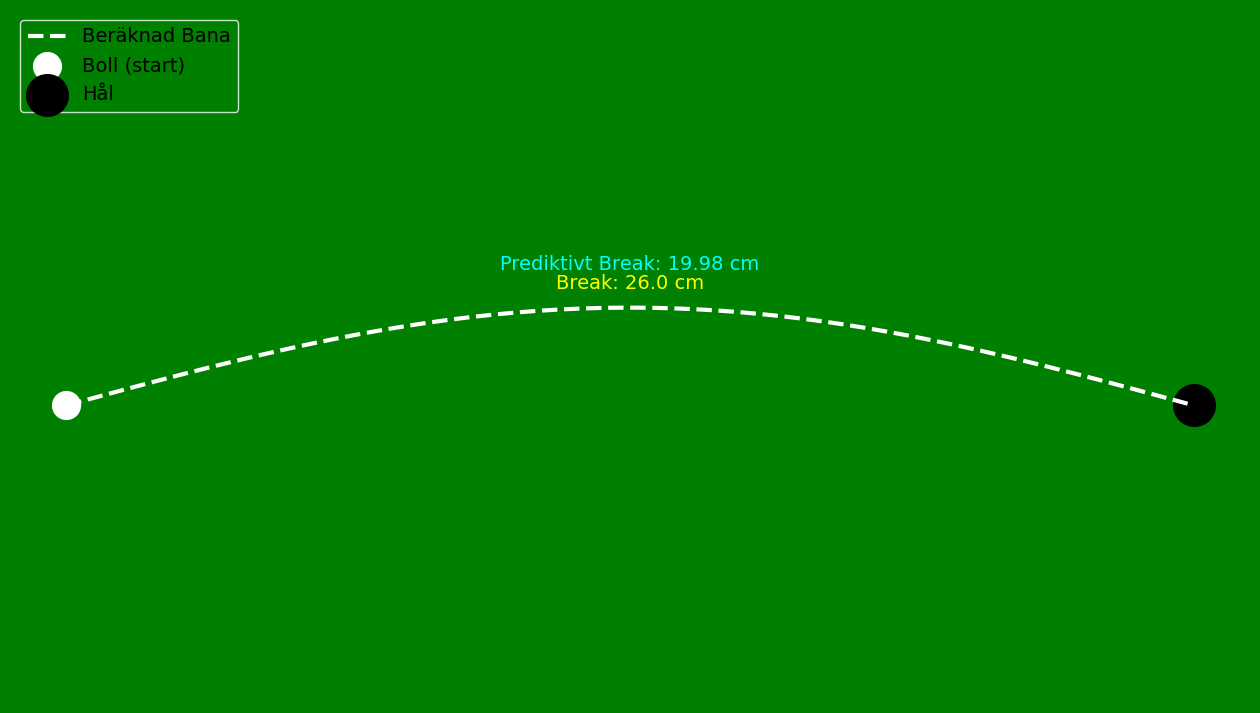

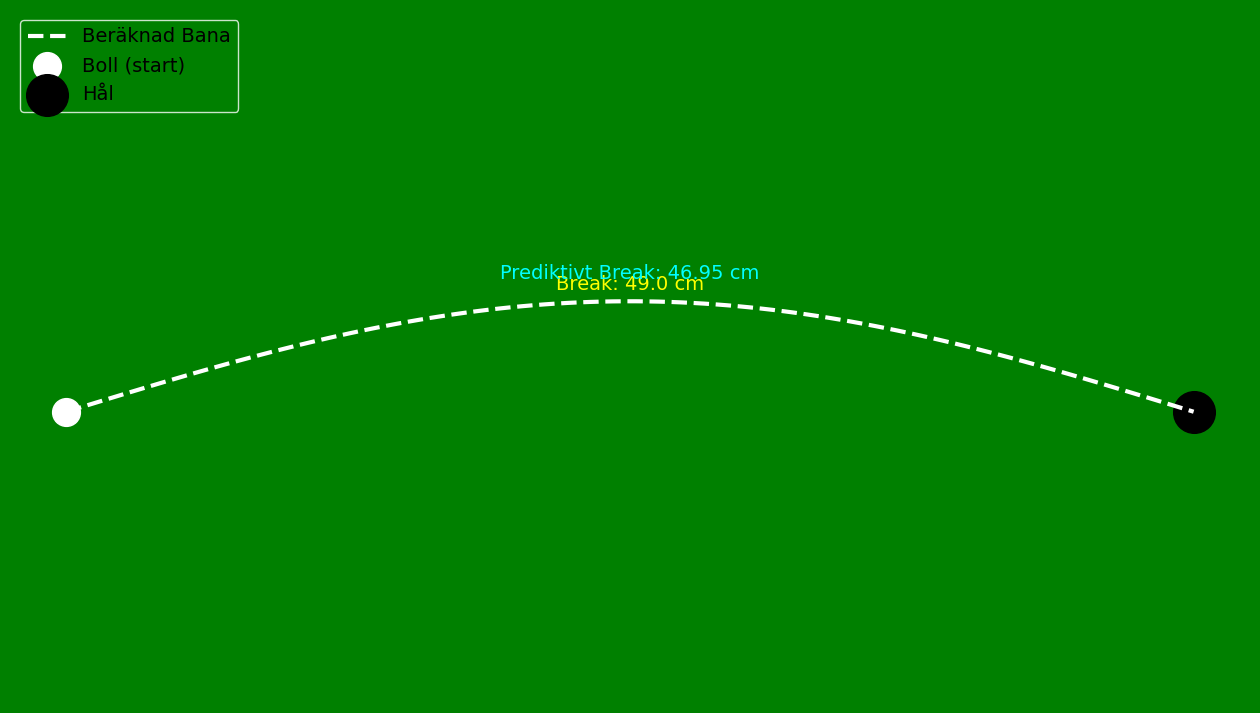

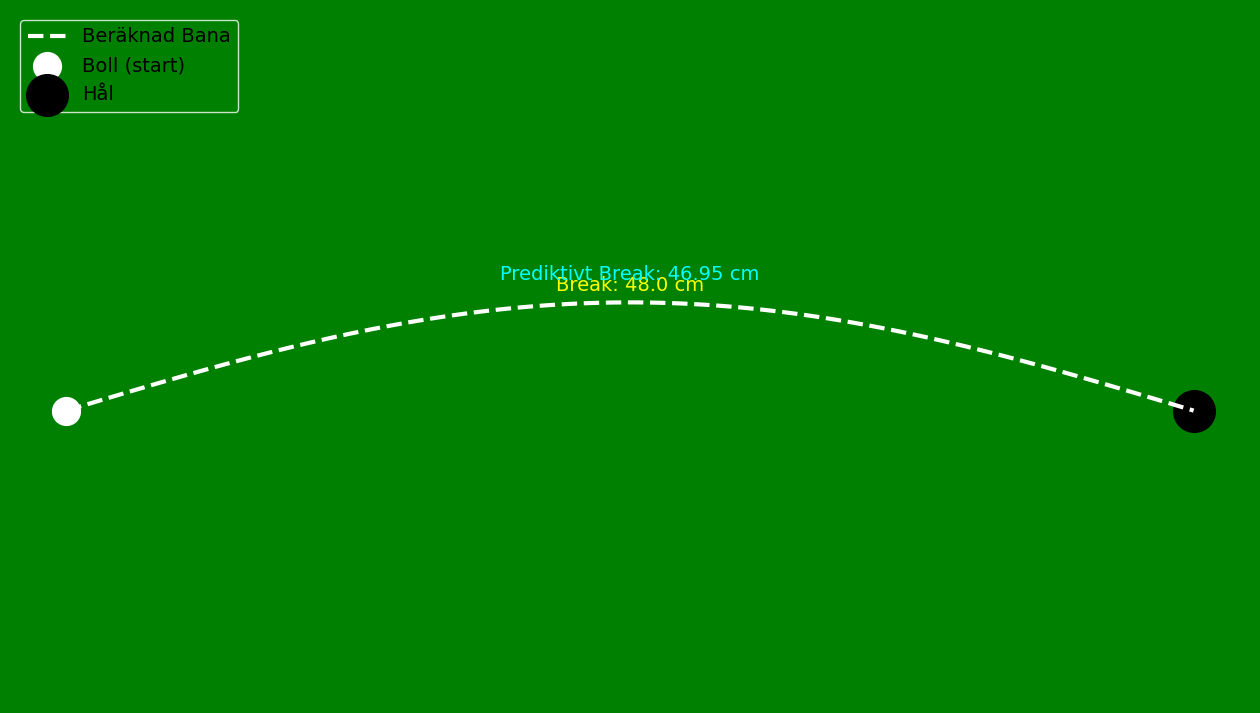

In [ ]:
# Installera pyngrok, Flask och scikit-learn
!pip install pyngrok Flask scikit-learn

from flask import Flask, render_template_string, request
from pyngrok import ngrok
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp2d

# Konfigurera ngrok med din autentiseringstoken
!ngrok config add-authtoken 2plE8lpWEDVGBuHVw5aZDbNEP8o_63y6MwHgWRMK62U3peMiw

# Flask-applikation
app = Flask(__name__)

# Dina tidigare mätvärden för break (i cm)
break_data = {
    1: [19, 27, 32, 41],  # 1% lutning
    2: [22, 32, 48, 57],  # 2% lutning
    3: [30, 51, 74, 84]   # 3% lutning
}

# Längder och lutningar som stöds i dina data
lengths = [3, 4, 5, 6]  # Längd i meter
slopes = [1, 2, 3]  # Lutning i procent

# Skapa interpolator för mätvärden
break_interpolator = interp2d(lengths, slopes, list(break_data.values()), kind='linear')

# Träna en prediktiv modell
def train_predictive_model():
    # Skapa dataset baserat på dina mätvärden
    X = []
    y = []
    for slope, values in break_data.items():
        for i, length in enumerate(lengths):
            X.append([slope, length])  # Lutning och längd som features
            y.append(values[i])  # Break som target

    X = np.array(X)
    y = np.array(y)

    # Polynomisk regression för bättre passning
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)

    # Träna modellen
    model = LinearRegression()
    model.fit(X_poly, y)

    return model, poly

predictive_model, poly_transformer = train_predictive_model()

# Funktion för att beräkna break med den prediktiva modellen
def predict_break(slope, length):
    X = np.array([[slope, length]])
    X_poly = poly_transformer.transform(X)
    predicted_break = predictive_model.predict(X_poly)
    return round(predicted_break[0], 2)

# Funktion för att generera visualisering
def generate_visualization(slope, length, break_value, predicted_break):
    """
    Skapar en visualisering av puttens bana.
    """
    x = np.linspace(0, length, 100)
    y = np.sin(np.pi * x / length) * (break_value / 100)  # Beräknad bana

    # Justera storleken på figuren
    fig, ax = plt.subplots(figsize=(16, 9))  # Fullskärmsformat (16:9)
    fig.patch.set_facecolor("green")
    ax.set_facecolor("green")

    # Bollens beräknade bana
    ax.plot(x, y, color="white", linestyle="--", linewidth=3, label="Beräknad Bana")

    # Bollens start- och slutposition
    ax.scatter([0], [0], color="white", s=400, label="Boll (start)")
    ax.scatter([length], [0], color="black", s=900, label="Hål")

    # Text som visar breaket
    ax.text(length / 2, max(y) + 0.05, f"Break: {break_value} cm", color="yellow", fontsize=14, ha="center")
    ax.text(length / 2, max(y) + 0.1, f"Prediktivt Break: {predicted_break} cm", color="cyan", fontsize=14, ha="center")

    # Extra detaljer och inställningar
    ax.legend(loc="upper left", fontsize=14, facecolor="green", edgecolor="white")
    ax.axis("off")
    ax.set_aspect("equal", adjustable="datalim")

    # Spara som bild
    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight", facecolor=fig.get_facecolor())
    buf.seek(0)
    return base64.b64encode(buf.getvalue()).decode("utf-8")

# Flask-route för startsidan
@app.route("/", methods=["GET", "POST"])
def index():
    html_form = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Putt Visualizer</title>
        <style>
            body { background-color: black; color: white; font-family: Arial, sans-serif; text-align: center; padding: 20px; }
            input, button, select { margin: 10px; padding: 10px; border-radius: 5px; border: none; }
            button { background-color: white; color: black; font-weight: bold; }
            .container { background-color: #333; padding: 20px; border-radius: 10px; display: inline-block; }
            h1 { font-size: 2.5em; text-transform: uppercase; margin-bottom: 20px; color: #00FF00; }
        </style>
    </head>
    <body>
        <h1>Putt Visualizer</h1>
        <div class="container">
            <form method="POST">
                <label for="slope">Lutning (%):</label><br>
                <input type="number" step="0.1" id="slope" name="slope" required><br>
                <label for="length">Längd (m):</label><br>
                <input type="number" step="0.1" id="length" name="length" required><br>
                <label for="stimp">Stimphastighet:</label><br>
                <input type="number" step="0.1" id="stimp" name="stimp" required><br>
                <label for="model">Modell:</label><br>
                <select id="model" name="model">
                    <option value="combined">Kombinerad</option>
                    <option value="empirical">Empirisk</option>
                    <option value="physics">Fysikalisk</option>
                </select><br>
                <button type="submit">Beräkna och visualisera</button>
            </form>
        </div>
    </body>
    </html>
    """
    if request.method == "POST":
        try:
            slope = float(request.form.get("slope", "").strip())
            length = float(request.form.get("length", "").strip())
            stimp = float(request.form.get("stimp", "").strip())
            model = request.form.get("model", "combined")

            # Beräkna break-värden
            break_value = calculate_break(slope, length, stimp, model=model)
            predicted_break = predict_break(slope, length)

            # Skapa visualisering
            visualization = generate_visualization(slope, length, break_value, predicted_break)

            # Returnera resultaten och visualiseringen
            return (
                f"<h2 style='color:white;'>Beräknat Break: {break_value} cm</h2>"
                f"<h3 style='color:cyan;'>Prediktivt Break: {predicted_break} cm</h3>"
                f"<img src='data:image/png;base64,{visualization}' alt='Putt Visualisering' />"
            )
        except ValueError:
            return "<h3 style='color:red;'>Alla fält måste vara numeriska!</h3>" + html_form
        except Exception as e:
            return f"<h3 style='color:red;'>Ett oväntat fel inträffade: {e}</h3>" + html_form
    return render_template_string(html_form)

# Starta ngrok och Flask
public_url = ngrok.connect(5000)
print(f"Din ngrok-länk är: {public_url}")
app.run(port=5000)